In [27]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [3]:
tf.__version__

'2.2.0'

In [4]:
myMinMaxScaler = MinMaxScaler()

In [5]:
import_df = pd.read_csv('20171021_20171124_1min.csv', index_col = 0, date_parser = pd.to_datetime)
import_df

,open,high,low,close,average
timestamp,,,,,
2017-10-21 00:00:00+00:00,6018.7,6022.1,6011.0,6020.0,6016.795301
2017-10-21 00:01:00+00:00,6019.9,6020.0,6014.2,6014.3,6018.435888
2017-10-21 00:02:00+00:00,6014.3,6016.6,6012.1,6012.1,6014.576291
2017-10-21 00:03:00+00:00,6012.1,6014.2,6012.1,6013.0,6012.818012
2017-10-21 00:04:00+00:00,6012.9,6018.0,6012.8,6015.8,6017.010478
...,...,...,...,...,...
2017-11-24 23:55:00+00:00,8221.0,8221.0,8220.5,8221.0,8220.783234
2017-11-24 23:56:00+00:00,8221.0,8222.5,8218.0,8218.0,8220.265747
2017-11-24 23:57:00+00:00,8218.0,8218.0,8211.0,8211.5,8213.875742


# Train / Test Split

In [7]:
import_df.shape

(50400, 5)

In [10]:
test_size = int(import_df.shape[0] / 3)
train_size = import_df.shape[0] - test_size
train_size

33600

In [35]:
train_df = import_df[:train_size]
test_df = import_df[train_size:]

# TS Analysis

In [28]:
train_y_orig = train_df.close

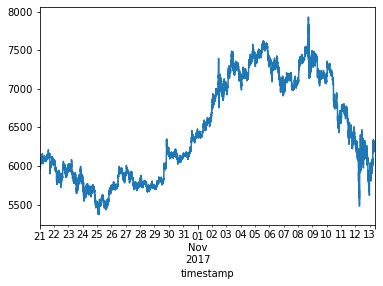

In [29]:
train_y_orig.plot();

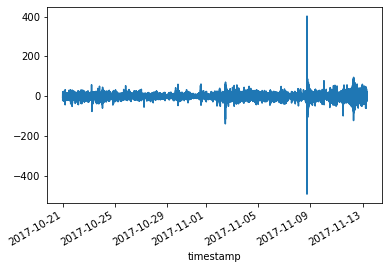

In [32]:
train_y_1dif = (train_y_orig - train_y_orig.shift(1)).dropna()
train_y_1dif.plot();

In [34]:
adfuller(train_y_1dif)

(-25.025641885648177,
 0.0,
 52,
 33518,
 {'1%': -3.4305451130997144,
  '5%': -2.861626235048506,
  '10%': -2.5668159002269144},
 254658.27741592482)

p-value is 0, therefore reject that the series has unit root, aka series is stationary.

# LSTM


In [198]:
window_size = 20
look_ahead = 1
y_train = np.array(train_df.close[window_size + look_ahead:])
data_points_train = y_train.shape[0]
data_points_train
y_test = np.array(test_df.close[window_size + look_ahead:])
data_points_test = y_test.shape[0]
data_points_train, data_points_test

(33579, 16779)

In [199]:
X_train = np.zeros((data_points_train, window_size, 5))
X_test = np.zeros((data_points_test, window_size, 5))

In [200]:
for i in range(data_points_train):
    X_train[i] = train_df.iloc[:window_size,].values
for i in range(data_points_test):   
    X_test[i] = test_df.iloc[:window_size,].values

In [206]:
train_data_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
BATCH_SIZE = 1
BUFFER_SIZE = 10000
train_data_tf = train_data_tf.cache().batch(BATCH_SIZE).repeat()

In [207]:
test_data_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))
BATCH_SIZE = 1
BUFFER_SIZE = 10000
test_data_tf = test_data_tf.cache().batch(BATCH_SIZE).repeat()

In [218]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(8,
                                          return_sequences=True,
                                          input_shape=X_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')
# multi_step_model.compile(optimizer='adam', loss='mse')

In [216]:
for x, y in train_data_tf.take(1):
  print (multi_step_model.predict(x).shape)

(1, 1)


In [219]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10



multi_step_history = multi_step_model.fit(train_data_tf, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=test_data_tf,
                                          validation_steps=100)


Epoch 1/10
2000/2000 [==============================] - 19s 9ms/step - loss: 36428968.0000 - val_loss: 39863920.0000
Epoch 2/10
2000/2000 [==============================] - 19s 9ms/step - loss: 34656732.0000 - val_loss: 39838904.0000
Epoch 3/10
2000/2000 [==============================] - 19s 9ms/step - loss: 32108518.0000 - val_loss: 39814168.0000
Epoch 4/10
2000/2000 [==============================] - 19s 9ms/step - loss: 31848626.0000 - val_loss: 39788824.0000
Epoch 5/10
2000/2000 [==============================] - 19s 9ms/step - loss: 34110668.0000 - val_loss: 39763408.0000
Epoch 6/10
2000/2000 [==============================] - 18s 9ms/step - loss: nan - val_loss: nan
Epoch 7/10
2000/2000 [==============================] - 18s 9ms/step - loss: nan - val_loss: nan
Epoch 8/10
2000/2000 [==============================] - 18s 9ms/step - loss: nan - val_loss: nan
Epoch 9/10
2000/2000 [==============================] - 19s 9ms/step - loss: nan - val_loss: nan
Epoch 10/10
 124/2000 [>...

KeyboardInterrupt: 

In [187]:
def create_time_steps(length):
      return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = 1

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


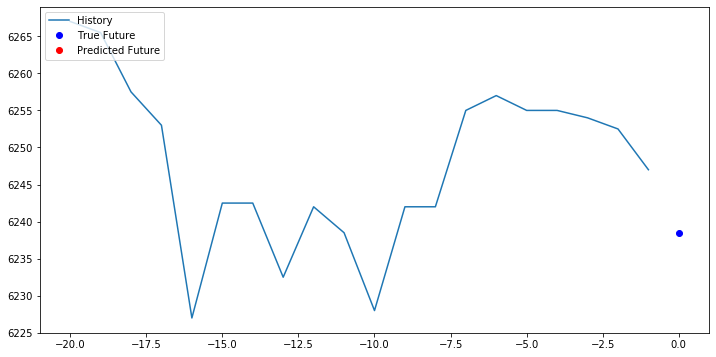

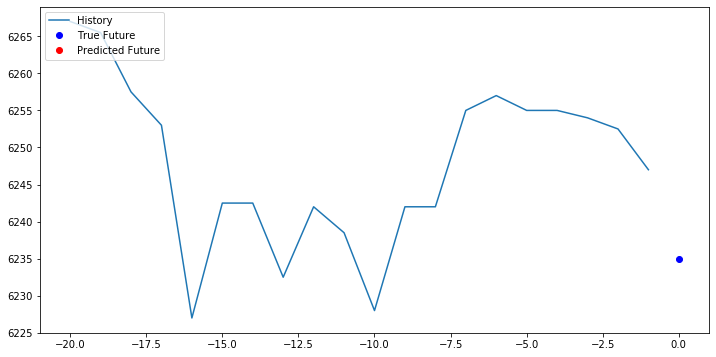

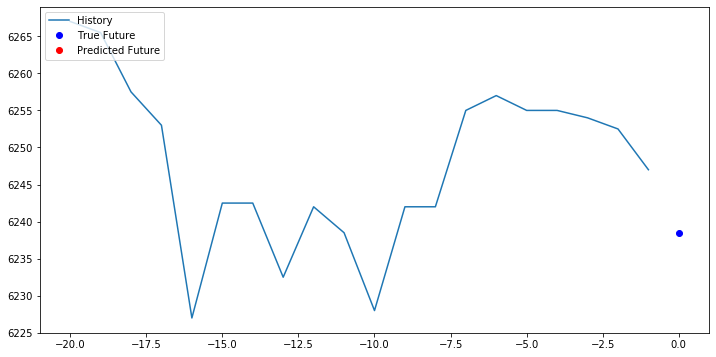

In [214]:
for x, y in test_data_tf.take(3):
      multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0]);

In [197]:
for x, y in test_data_tf.take(1):
  print(multi_step_model.predict(x))

[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
